In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from collections import defaultdict
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import random
import cv2
from collections import Counter
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import load_img,img_to_array,to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
TRAIN_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
TRAIN_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels'
VALID_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
VALID_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels'
TEST_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'
TEST_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels'

TARGET_SIZE = [225,225]
def load_images_and_labels(image_dir, label_dir):
    images = []
    class_labels = [] 
    polygons = [] 
    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg") or img_name.endswith(".png"):  
            img_path = os.path.join(image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, TARGET_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
            label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
            with open(label_path, "r") as f:
                label_content = f.read().strip()  
            if label_content:  
                components = label_content.split()
                class_label = components[0]
                polygon_coords = list(map(float, components[1:])) 
            else:  
                class_label = 'no_fracture'  
                polygon_coords = [] 

            # Append to lists
            images.append(image)
            class_labels.append(class_label)
            polygons.append(polygon_coords)

    return np.array(images), np.array(class_labels), polygons

# Load images, class labels, and polygons
train_images, train_class_labels, train_polygons = load_images_and_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
valid_images, valid_class_labels, valid_polygons = load_images_and_labels(VALID_IMAGE_DIR, VALID_LABEL_DIR)
test_images, test_class_labels, test_polygons = load_images_and_labels(TEST_IMAGE_DIR, TEST_LABEL_DIR)

print(f"Loaded {len(train_images)} images, {len(train_class_labels)} class labels, and {len(train_polygons)} sets of polygons.")
print(f"Loaded {len(valid_images)} images, {len(valid_class_labels)} class labels, and {len(valid_polygons)} sets of polygons.")
print(f"Loaded {len(test_images)} images, {len(test_class_labels)} class labels, and {len(test_polygons)} sets of polygons.")

Loaded 3631 images, 3631 class labels, and 3631 sets of polygons.
Loaded 348 images, 348 class labels, and 348 sets of polygons.
Loaded 169 images, 169 class labels, and 169 sets of polygons.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

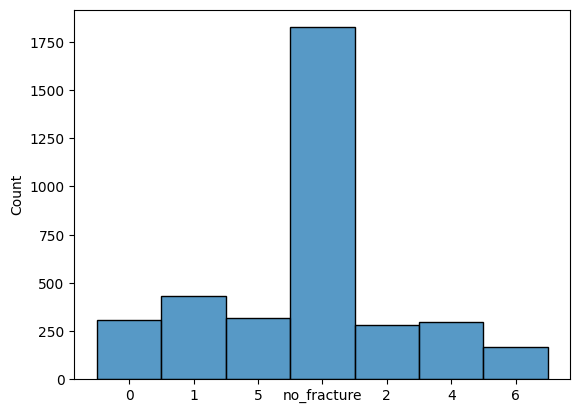

In [3]:
sns.histplot(train_class_labels)

In [4]:
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(train_class_labels)
valid_labels_enc = label_encoder.transform(valid_class_labels)
test_labels_enc = label_encoder.transform(test_class_labels)

print(label_encoder.classes_)  # to know the actual labels

['0' '1' '2' '4' '5' '6' 'no_fracture']


In [5]:

# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups = defaultdict(list)

for img, label in zip(train_images, train_labels_enc):  # assuming integer-encoded labels
    class_groups[label].append(img)

# Convert lists to arrays
for k in class_groups:
    class_groups[k] = np.array(class_groups[k])

In [6]:
no_fracture_label = 6 
train_images_list, train_labels_list = [], []

for label, images in class_groups.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        train_images_list.append(images)
        train_labels_list.extend([0] * len(images))
    else:
        train_images_list.append(images)
        train_labels_list.extend([1] * len(images))

train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.array(train_labels_list)

print(np.unique(train_labels, return_counts=True))

(array([0, 1]), array([1827, 1804]))


In [7]:
# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups_1 = defaultdict(list)

for img, label in zip(valid_images, valid_labels_enc):  # assuming integer-encoded labels
    class_groups_1[label].append(img)

# Convert lists to arrays
for k in class_groups_1:
    class_groups_1[k] = np.array(class_groups_1[k])

In [8]:

valid_images_list, valid_labels_list = [], []

for label, images in class_groups_1.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        valid_images_list.append(images)
        valid_labels_list.extend([0] * len(images))
    else:
        valid_images_list.append(images)
        valid_labels_list.extend([1] * len(images))

valid_images = np.concatenate(valid_images_list, axis=0)
valid_labels = np.array(valid_labels_list)

print(np.unique(valid_labels, return_counts=True))# no_fracture_label = 0 (adjust if needed)

(array([0, 1]), array([175, 173]))


In [9]:
# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups_2 = defaultdict(list)

for img, label in zip(test_images, test_labels_enc):  # assuming integer-encoded labels
    class_groups_2[label].append(img)

# Convert lists to arrays
for k in class_groups_2:
    class_groups_2[k] = np.array(class_groups_2[k])

In [10]:
# no_fracture_label = 0 (adjust if needed)
test_images_list, test_labels_list = [], []

for label, images in class_groups_2.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        test_images_list.append(images)
        test_labels_list.extend([0] * len(images))
    else:
        test_images_list.append(images)
        test_labels_list.extend([1] * len(images))

test_images = np.concatenate(test_images_list, axis=0)
test_labels = np.array(test_labels_list)

print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([86, 83]))


In [11]:
counter = Counter(train_labels)
max_count = max(counter.values())

balanced_images, balanced_labels = [], []

for cls in [0,1]:
    images = train_images[train_labels == cls]
    count_needed = max_count - len(images)

    # Always add original images
    balanced_images.extend(images)
    balanced_labels.extend([cls] * len(images))

    # Add augmented images
    for i in range(count_needed):
        img = images[i % len(images)]
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.resize(img, (225, 225))
        balanced_images.append(img.numpy())
        balanced_labels.append(cls)

balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)

print("Balanced counts:", Counter(balanced_labels))


Balanced counts: Counter({0: 1827, 1: 1827})


In [12]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")


In [13]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

# Apply augmentation inside pipeline
train_ds = train_ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Valid/test data: no augmentation
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [14]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(225,225,3))
base_model.trainable = False

inputs = layers.Input(shape=(225,225,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_ds, validation_data=valid_ds, epochs=20,
    callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.7486 - loss: 0.5768 - val_accuracy: 0.4971 - val_loss: 1.0024
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5552 - loss: 0.8715 - val_accuracy: 0.5029 - val_loss: 1.0065
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.5585 - loss: 0.8657 - val_accuracy: 0.5057 - val_loss: 0.9274
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.5845 - loss: 0.8087 - val_accuracy: 0.5115 - val_loss: 0.9152
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.6047 - loss: 0.7803 - val_accuracy: 0.5287 - val_loss: 0.8558
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.6120 - loss: 0.7598 - val_accuracy: 0.5402 - val_loss: 0.8826
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6007 - loss: 0.7819 - val_accuracy: 0.5489 - val_loss: 0.8794
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 176s 2

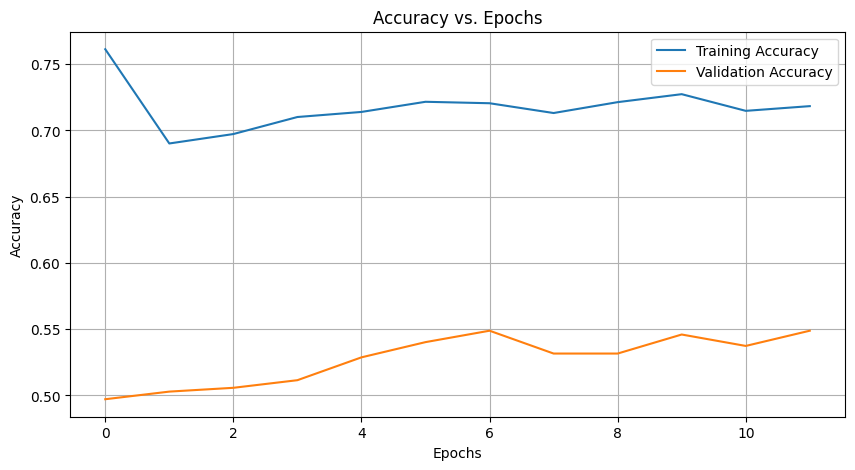

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Confusion Matrix:
 [[ 9 77]
 [ 0 83]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.10      0.19        86
           1       0.52      1.00      0.68        83

    accuracy                           0.54       169
   macro avg       0.76      0.55      0.44       169
weighted avg       0.76      0.54      0.43       169

ROC AUC: 0.7703838610254974


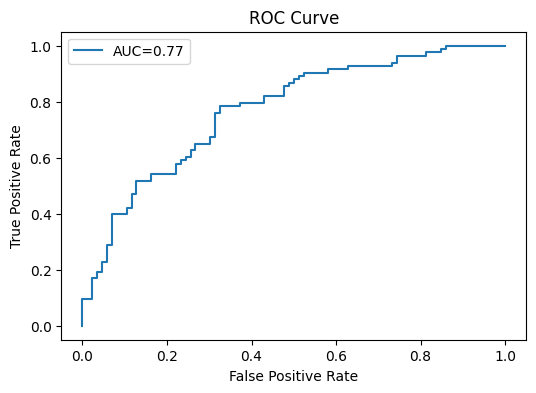

In [16]:
# Predict on test set
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_labels, y_pred))
print("ROC AUC:", roc_auc_score(test_labels, y_pred_probs))

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(test_labels, y_pred_probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [17]:
# Unfreeze top N layers of base_model
base_model.trainable = True

# Optionally freeze bottom layers
fine_tune_at = len(base_model.layers) - 20  # unfreeze last 20 layers
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= fine_tune_at

# Compile with smaller lr
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # lower lr
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training
fine_tune_history = model.fit(
    train_ds, validation_data=valid_ds, epochs=20,
    callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.5783 - loss: 0.6870 - val_accuracy: 0.6667 - val_loss: 0.6310
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.5398 - loss: 0.7094 - val_accuracy: 0.6983 - val_loss: 0.5887
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5238 - loss: 0.7387 - val_accuracy: 0.7011 - val_loss: 0.5857
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5122 - loss: 0.7488 - val_accuracy: 0.7155 - val_loss: 0.5823
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5085 - loss: 0.7480 - val_accuracy: 0.7241 - val_loss: 0.5771
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5070 - loss: 0.7395 - val_accuracy: 0.7184 - val_loss: 0.5728
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5127 - loss: 0.7466 - val_accuracy: 0.7126 - val_loss: 0.5683
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.5165 - loss: 0.7352 - val_accu

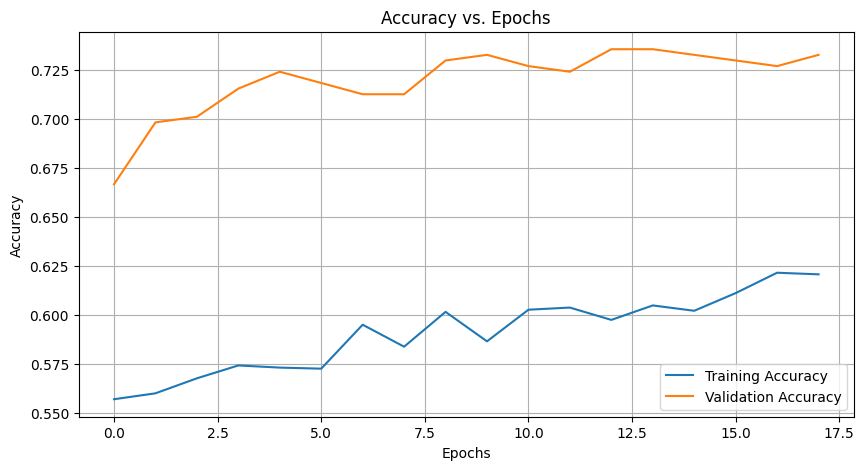

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Confusion Matrix:
 [[59 27]
 [25 58]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69        86
           1       0.68      0.70      0.69        83

    accuracy                           0.69       169
   macro avg       0.69      0.69      0.69       169
weighted avg       0.69      0.69      0.69       169

ROC AUC: 0.7750070047632389


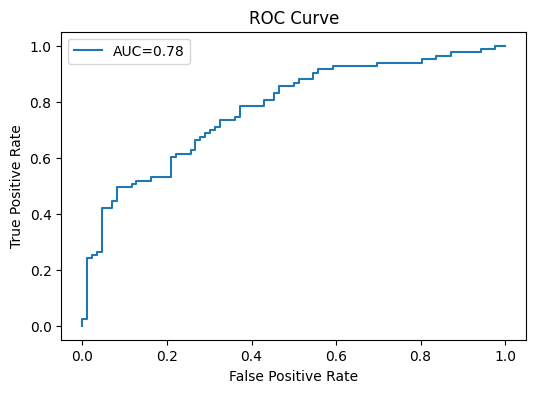

In [19]:
# Predict on test set
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_labels, y_pred))
print("ROC AUC:", roc_auc_score(test_labels, y_pred_probs))

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(test_labels, y_pred_probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [20]:
base_model = ResNet152V2(weights="imagenet", include_top=False, input_shape=(225,225,3))
base_model.trainable = False

inputs = layers.Input(shape=(225,225,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_ds, validation_data=valid_ds, epochs=20,
    callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 960s 8s/step - accuracy: 0.8402 - loss: 28.6262 - val_accuracy: 0.4971 - val_loss: 85.6928
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 929s 8s/step - accuracy: 0.7303 - loss: 62.2856 - val_accuracy: 0.4971 - val_loss: 67.5048
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 927s 8s/step - accuracy: 0.7575 - loss: 50.4635 - val_accuracy: 0.4971 - val_loss: 52.3206
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 928s 8s/step - accuracy: 0.7575 - loss: 46.2733 - val_accuracy: 0.5460 - val_loss: 11.6653
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 928s 8s/step - accuracy: 0.7970 - loss: 25.5039 - val_accuracy: 0.5115 - val_loss: 17.0950
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 930s 8s/step - accuracy: 0.7885 - loss: 22.8845 - val_accuracy: 0.5086 - val_loss: 22.8184
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 926s 8s/step - accuracy: 0.7778 - loss: 28.2406 - val_accuracy: 0.4971 - val_loss: 35.0513
Epoch 8/20
115/115 ━━━━━━━━━━━

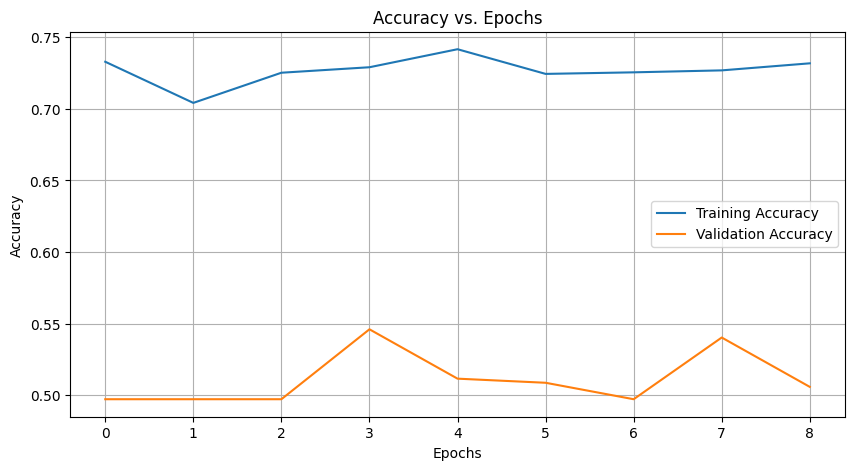

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# target_count = max(len(v) for v in class_groups.values())  # make all classes equal to max class

# print("Target per class:", target_count)

In [23]:
# len(class_groups[6])

In [24]:
# augmented_images = []
# augmented_labels = []

# for label, images in class_groups.items():
#     if len(images) == 0:
#         print(f"Skipping class {label} (no images)")
#         continue

#     count_needed = target_count - len(images)
#     print(f"Augmenting class {label} by {count_needed} samples")

#     # ✅ Always add original images first
#     augmented_images.extend(images)
#     augmented_labels.extend([label] * len(images))

#     # ➕ Add augmented images to match target count
#     for i in range(count_needed):
#         img = images[i % len(images)]
#         aug_img = tf.image.random_flip_left_right(img)
#         aug_img = tf.image.random_brightness(aug_img, max_delta=0.1)
#         aug_img = tf.image.random_contrast(aug_img, 0.9, 1.1)
#         aug_img = tf.image.resize(aug_img, (225, 225))
#         aug_img = tf.cast(aug_img, tf.uint8)
#         augmented_images.append(aug_img.numpy())
#         augmented_labels.append(label)

In [25]:
# sns.histplot(augmented_labels)

In [26]:
# aug_images = np.array(augmented_images)
# aug_labels = np.array(augmented_labels)

# # Shuffle
# perm = np.random.permutation(len(aug_images))
# aug_images = aug_images[perm]
# aug_labels = aug_labels[perm]

In [27]:
# train_images = aug_images / 255.0
# valid_images = valid_images / 255.0
# test_images = test_images / 255.0

In [28]:
# num_classes = len(label_encoder.classes_)
# train_labels_cat = to_categorical(aug_labels, num_classes)
# valid_labels_cat = to_categorical(valid_labels_enc, num_classes)
# test_labels_cat = to_categorical(test_labels_enc, num_classes)

In [29]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     zoom_rangfrom tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

# # Setup EfficientNet
# base_model = EfficientNetB0(
#     weights="imagenet",
#     include_top=False,
#     input_shape=(225, 225, 3)
# )
# base_model.trainable = False

# inputs = Input(shape=(225, 225, 3))
# x = base_model(inputs, training=False)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

# model = models.Model(inputs, outputs)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Dataset pipeline
# train_ds = tf.data.Dataset.from_tensor_slices((aug_images, aug_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)
# val_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)

# # Train
# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)]
# )e=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],
#     fill_mode='nearest'
# )
# datagen.fit(train_images)

In [30]:
# len(label_encoder.classes_)

In [31]:
# import tensorflow as tf
# import keras_cv
# from tensorflow.keras import layers, models, callbacks
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

# # Parameters
# IMAGE_SIZE = 225
# BATCH_SIZE = 32
# NUM_CLASSES = len(label_encoder.classes_)  # from your label encoder
# EPOCHS = 20


# # Setup EfficientNet
# base_model = EfficientNetB0(
#     weights="imagenet",
#     include_top=False,
#     input_shape=(225, 225, 3)
# )
# base_model.trainable = False

# inputs = Input(shape=(225, 225, 3))
# x = base_model(inputs, training=False)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

# model = models.Model(inputs, outputs)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Dataset pipeline
# train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)
# val_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)

# # Train
# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)]
# )


In [32]:
# loss, acc = model.evaluate(test_images, test_labels_cat, batch_size=32)
# print(f"Test Accuracy: {acc:.4f}")

In [33]:
# y_pred = model.predict(test_images)
# y_pred = tf.argmax(y_pred,axis=1).numpy()

# print(classification_report(test_labels_enc, y_pred, target_names=label_encoder.classes_))

In [34]:
# model.predict(test_images)